$$
\newcommand{\parens}[1]{\mathopen{}\left(#1\right)\mathclose{}}
\newcommand{\bracks}[1]{\mathopen{}\left[#1\right]\mathclose{}}
\newcommand{\braces}[1]{\mathopen{}\left\{#1\right\}\mathclose{}}
\newcommand{\abs}[1]{\mathopen{}\left\lvert#1\right\rvert\mathclose{}}
\newcommand{\norm}[1]{\mathopen{}\left\lVert#1\right\rVert\mathclose{}}
\renewcommand{\vec}[1]{\boldsymbol{\mathbf{#1}}}
\newcommand{\mat}[1]{\mathbf{#1}}
\newcommand{\tpose}[1]{#1^T}
\newcommand{\inv}[1]{#1^{-1}}
\newcommand{\Matrix}[1]{
  \begin{bmatrix}
    #1
  \end{bmatrix}
}
\newcommand{\seq}[1]{1, 2, \ldots, #1}
\newcommand{\reals}{\mathbb{R}}
\newcommand{\mper}{\,\text{.}}
\newcommand{\mcom}{\,\text{,}}
$$

(time-series)=
# Time Series Forecasting

## Summary

Using all recorded annual temperatures averages (from 1850 to 2020), I use [Prophet](https://facebook.github.io/prophet/) to forecast annual temperatures for the next two decades.


## Data Source

Average northern hemisphere temperature data was obtained from [https://www.metoffice.gov.uk/hadobs/hadcrut5/](https://www.metoffice.gov.uk/hadobs/hadcrut5/), specifically the "HadCRUT5 analysis time series: ensemble means and uncertainties".
The temperatures are expressed as deviations, or anomalies, from reference temperatures over the period of 1961--1990; for details [see here](https://crudata.uea.ac.uk/cru/data/temperature/#faq5).
Each anomaly is a best estimate calculated from an ensemble of 100 time series, hence confidence intervals are present in the dataset.
For the purposes of this analysis, I will just use the point estimate.

(data-exploration)=
## Data Exploration

Let's load in the data and examine it:

In [1]:

import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('./globwarm.csv')
df.head(3)

,Time,Anomaly (deg C),Lower confidence limit (2.5%),Upper confidence limit (97.5%)
0,1850,-0.435791,-0.635680,-0.235902
1,1851,-0.219249,-0.428398,-0.010100
2,1852,-0.235702,-0.457689,-0.013715


In [2]:

df.tail(3)

,Time,Anomaly (deg C),Lower confidence limit (2.5%),Upper confidence limit (97.5%)
169,2019,1.143743,1.108290,1.179197
170,2020,1.275727,1.236863,1.314590
171,2021,1.004906,0.764207,1.245604


Since 2021 data collection is still ongoing, the confidence limits are much wider.
For simplicity, I'll drop this point from the analysis.

In [3]:

df = df[df.Time <= 2020]

Next, let's plot the data:

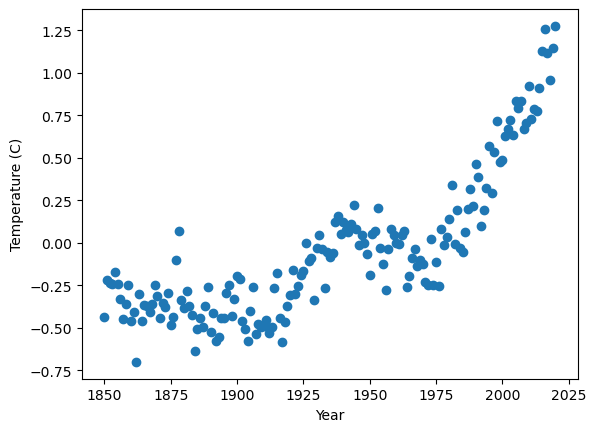

In [4]:

fig, ax = plt.subplots()
ax.plot(df.Time, df["Anomaly (deg C)"], 'o')
ax.set(xlabel='Year', ylabel='Temperature (C)')
plt.show()

There is also clearly a nonlinear trend amidst the random variation from year to year.
We also expect some long term cyclical patterns, for instance [Milankovitch cycles](https://en.wikipedia.org/wiki/Milankovitch_cycles) due to variations in Earth's movement relative to the Sun.
However, these patterns are difficult to extract because we have just under 200 years of data to work with.
These cyclical patterns are very important, however, because we don't have access to more granular data with daily, weekly, and/or yearly variation typically present in business problems.
For this reason, [Prophet](https://facebook.github.io/prophet/) is useful as it can easily implement custom seasonalities.
It's also flexible in its ability to detect changepoints, another crucial parameter affecting model fit as we will see next.

## Building a Simple Forecast

First, we must format the data appropriately.
Prophet expects a two column dataframe with datestamps `ds` formatted like `YYYY-MM-DD` and numeric data `y`.

In [5]:

def format_years(years):
    """Convert numeric years to YYYY-MM-DD format, using an arbitrary day."""
    ds = [str(year) + "-12-31" for year in years]
    return ds

df = (
    df[["Time", "Anomaly (deg C)"]]
    .rename(columns={"Time": "ds", "Anomaly (deg C)": "y"})
)
df.ds = format_years(df.ds)
df.head(3)

,ds,y
0,1850-12-31,-0.435791
1,1851-12-31,-0.219249
2,1852-12-31,-0.235702


In [6]:

df.tail(3)

,ds,y
168,2018-12-31,0.959662
169,2019-12-31,1.143743
170,2020-12-31,1.275727


`df` is now ready for Prophet modeling, but as hinted in § [](data-exploration), a model built from defaults performs very poorly:
```{margin}
The INFO messages tell us weekly and daily seasonalities are disabled (by default) as they should be, because our data resolution is on much longer timescales.
```

Importing plotly failed. Interactive plots will not work.


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


/home/adam/projects/website/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/adam/projects/website/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/adam/projects/website/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -17.5035
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       217.559   0.000640947       66.6814           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     188       218.511    0.00158703       88.0943   2.803e-05       0.001      286  LS failed, Hessian reset 
     199       218.616   5.91156e-05       56.8093     0.07449           1      306   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     292       218.705   2.68884e-05       64.9809   3.837e-07       0.001      470  LS failed, Hessian reset 
     299       218.705   5.18845e-06       67.2586           1           1      478   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     334       218.706   2.36909e-06        77.496   3.097e-08       0.001      563  LS failed, Hessian rese

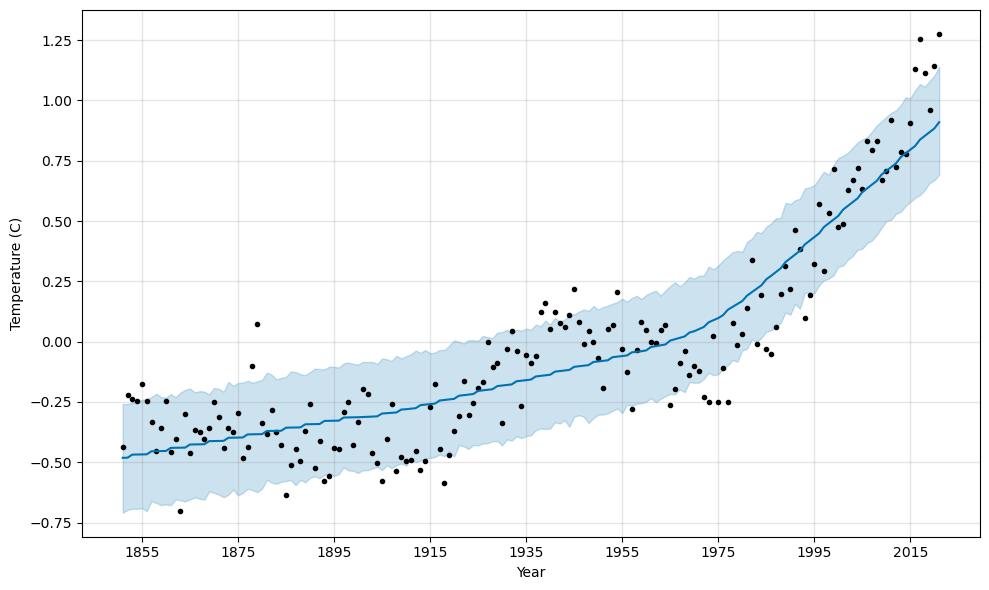

In [7]:

from prophet import Prophet

def plot_model_fit(model, df):
    """Fit and plot predictions of a Prophet() model on the training data."""
    model.fit(df)
    predictions = model.predict()
    model.plot(predictions, xlabel='Year', ylabel='Temperature (C)')

model = Prophet()
plot_model_fit(model, df)

The reason is that we need to account for long term cycles over many years.
A yearly seasonality is meaningless in this context, because we don't have sub-year level data.
Let's try again, disabling the usual seasonalities and implementing our own using the `add_seasonality()` method.
From the scatterplot of the raw data, any noticeable variation occurs after at least 50 years.
At this scale, the variation is relatively small, so the fit shouldn't be too flexible.
In other words, we shouldn't include too many Fourier terms, controlled by the `fourier_order` parameter.

/home/adam/projects/website/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/adam/projects/website/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/adam/projects/website/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -17.5035
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      53       218.827     0.0054749       100.245   5.445e-05       0.001       94  LS failed, Hessian reset 
      86       219.303   0.000428905       65.8946   5.252e-06       0.001      191  LS failed, Hessian reset 
      99       219.314   7.47284e-06       41.2342      0.5794      0.5794      211   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     160       219.835   0.000219902       48.0568   4.058e-06       0.001      343  LS failed, Hessian reset 
     193       219.863   0.000114599       67.8428   1.766e-06       0.001      422  LS failed, Hessian reset 
     199       219.865    2.8985e-06       48.9324      0.2933      0.2933      429   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     219       219.866   1.76065e-06         49.44   3.818e-08   

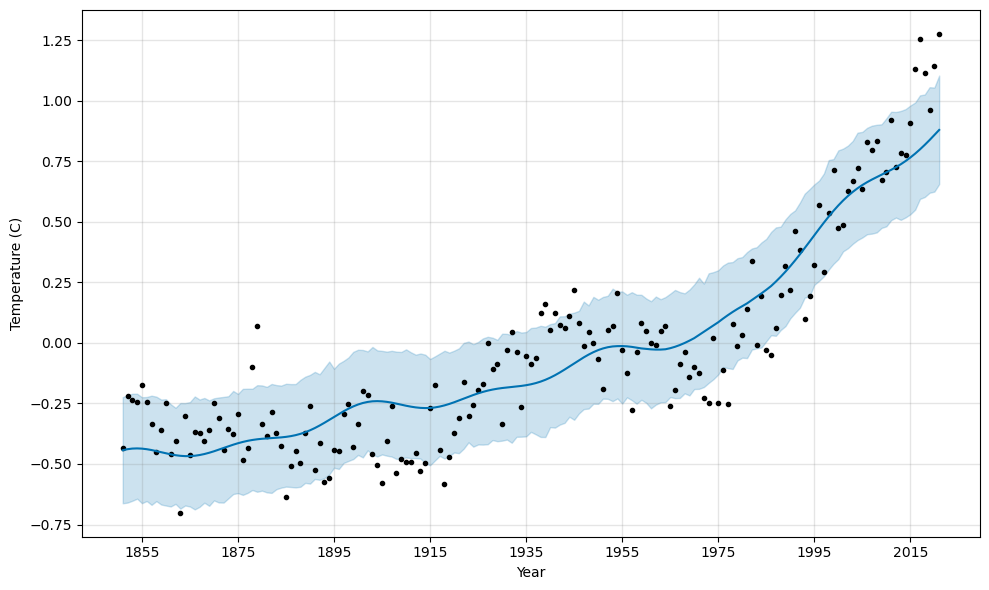

In [8]:

model = Prophet(
    daily_seasonality = False,
    weekly_seasonality = False,
    yearly_seasonality = False,
)
model.add_seasonality('50 years', period = 365*50, fourier_order = 2)
plot_model_fit(model, df)

The fit's a bit better in terms of smoothness, but still not great.
Increasing `fourier_order` just amounts to more more variation around a similar mean trend line.
Let's try increasing the seasonality period a bit more:

/home/adam/projects/website/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/adam/projects/website/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/adam/projects/website/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -17.5035
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      95       248.116   5.36108e-05       42.8226   8.505e-07       0.001      168  LS failed, Hessian reset 
      99       248.117   5.87883e-06       49.9379      0.8928     0.08928      175   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     158       248.125   4.68896e-07        57.519   8.193e-09       0.001      306  LS failed, Hessian reset 
     163       248.125   8.11851e-09       51.7867      0.1544      0.1544      312   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


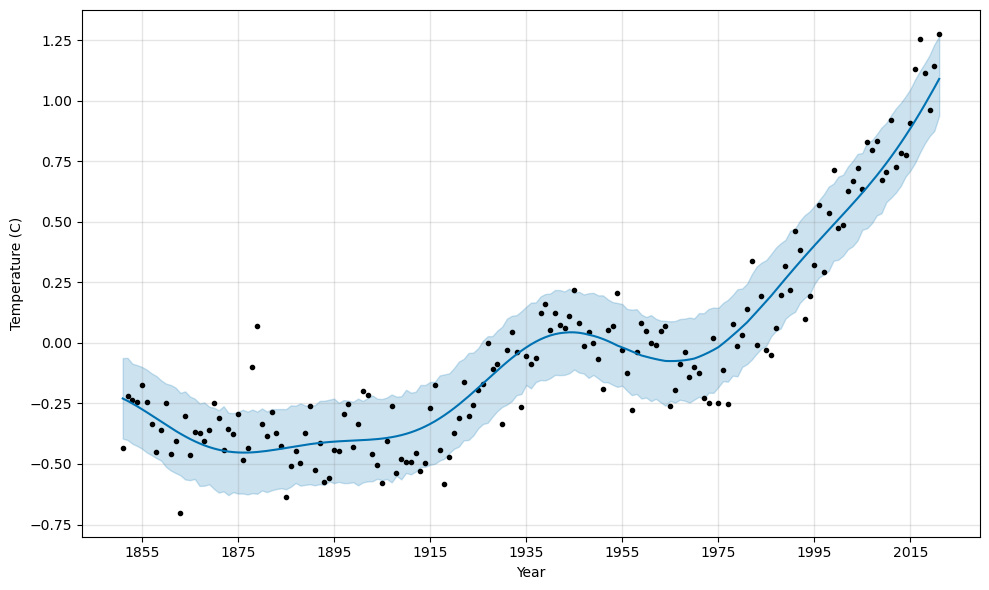

In [9]:

model = Prophet(
    daily_seasonality = False,
    weekly_seasonality = False,
    yearly_seasonality = False,
)
model.add_seasonality('centuryly', period = 365*100, fourier_order = 2)
plot_model_fit(model, df)

The fit is much better.
Let's see what it forecasts.

/home/adam/projects/website/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/adam/projects/website/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


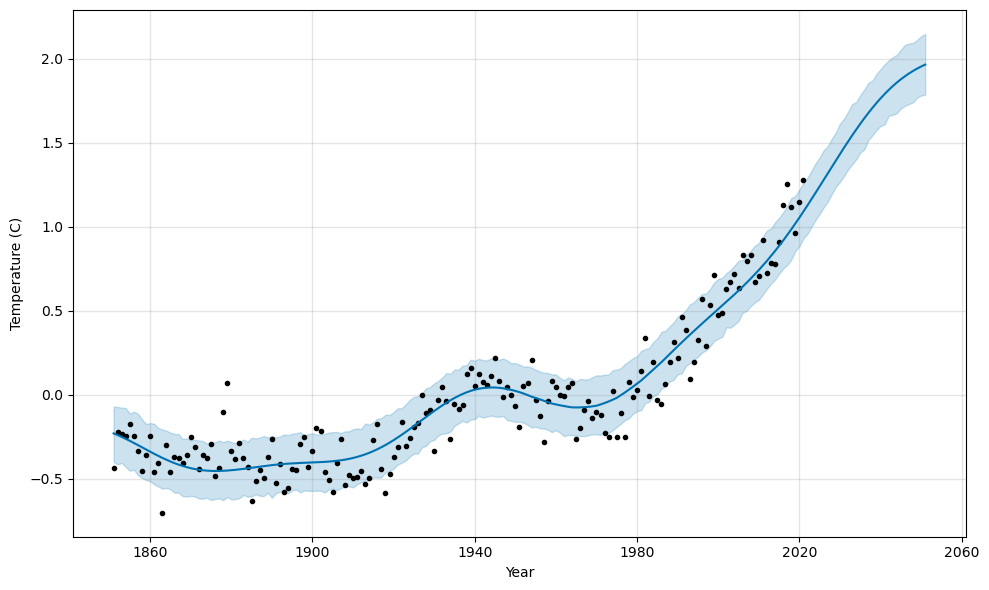

In [10]:

future = model.make_future_dataframe(periods=30, freq='Y')
forecast = model.predict(future)
model.plot(forecast, xlabel='Year', ylabel='Temperature (C)')
plt.show()

The model stays roughly linear with the latest data, but levels off due to the seasonality built into the model.

## Optimizing the Forecast

The previous hand-tuning was insightful, but largely experimental.
A more principled approach tunes the parameters based on some performance metric(s).
Cross-validation is often used for this, but we have to be a bit careful with time series data due to correlations between data points.
One approach preserves the ordering of time by training on the first (say) 100 years of data and testing on the next 20 years of data.
Then we train on the first 110 years of data and again test on the next 20 years of data.
We repeat this until we reach the end of the data.
Each batch gives us an estimate of errors of predictions made 1, 2, ..., 20 years in the future while preserving the ordering of time.
This approach can be implemented in Prophet as follows:

In [11]:

from prophet.diagnostics import cross_validation

df_cv = cross_validation(model, initial='36500 days', horizon='7300 days')
df_cv.head(3)

INFO:prophet:Making 6 forecasts with cutoffs between 1951-01-18 00:00:00 and 2001-01-05 00:00:00


  0%|          | 0/6 [00:00<?, ?it/s]

/home/adam/projects/website/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/adam/projects/website/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/adam/projects/website/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -5.25924
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      75       127.229   9.68385e-10       101.584     0.09599     0.09599       96   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/home/adam/projects/website/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/adam/projects/website/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/adam/projects/website/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -5.36242
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       139.461   9.76843e-05       103.123      0.7929      0.7929      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     143       139.524   4.58751e-05       102.166   4.693e-07       0.001      204  LS failed, Hessian reset 
     168       139.527    7.1662e-09       100.937      0.1476      0.1476      239   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/home/adam/projects/website/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/adam/projects/website/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/adam/projects/website/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -5.73025
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       153.794   3.71888e-06       105.159       0.349           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     138       153.795   7.36488e-09       106.455      0.4683      0.4683      176   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/home/adam/projects/website/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/adam/projects/website/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/adam/projects/website/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -6.64014
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      82       164.752   0.000308592       101.842   3.108e-06       0.001      141  LS failed, Hessian reset 
      99       164.769   1.70261e-06       99.5116      0.5224      0.5224      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     117       164.769   8.94213e-09       99.2085       0.177       0.177      184   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/home/adam/projects/website/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/adam/projects/website/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/adam/projects/website/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -14.1508
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      88       163.574      0.001071       107.114   9.956e-06       0.001      160  LS failed, Hessian reset 
      99       163.666   0.000165312       102.358      0.9734      0.9734      172   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     182       163.726   6.51677e-09       95.6481      0.2608      0.2608      276   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/home/adam/projects/website/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/adam/projects/website/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/adam/projects/website/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -12.6326
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       151.557   4.53253e-06       54.8127      0.5863      0.5863      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     174       151.578   5.73067e-05       84.3149   7.726e-07       0.001      277  LS failed, Hessian reset 
     199        151.58   2.07059e-07       47.3968      0.3915      0.3915      310   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     232        151.58   6.29633e-09       67.7881      0.2082           1      358   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,1951-12-31,-0.006353,-0.163867,0.151059,0.053849,1951-01-18
1,1952-12-31,-0.015820,-0.165441,0.132568,0.069817,1951-01-18
2,1953-12-31,-0.025520,-0.184239,0.126971,0.206579,1951-01-18


In [12]:

df_cv.tail(3)

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
117,2018-12-31,0.104307,-0.094205,0.287713,0.959662,2001-01-05
118,2019-12-31,0.115870,-0.088734,0.319167,1.143743,2001-01-05
119,2020-12-31,0.129318,-0.075923,0.337947,1.275727,2001-01-05


For example, we see the the first `cutoff` point is in 1960.
The model is trained on data up until the cutoff, then predictions (`yhat`) are made for the next 20 years.
The cutoff points are then incremented by 10 years until 2000.
I'll measure model performance using mean squared error (MSE), but a variety of metrics could be used.
We can plot MSE as a function of horizon length (how far in time the prediction is made) using `plot_cross_validation_metric()`;
unsurprisingly, performance is worse the farther out the window:

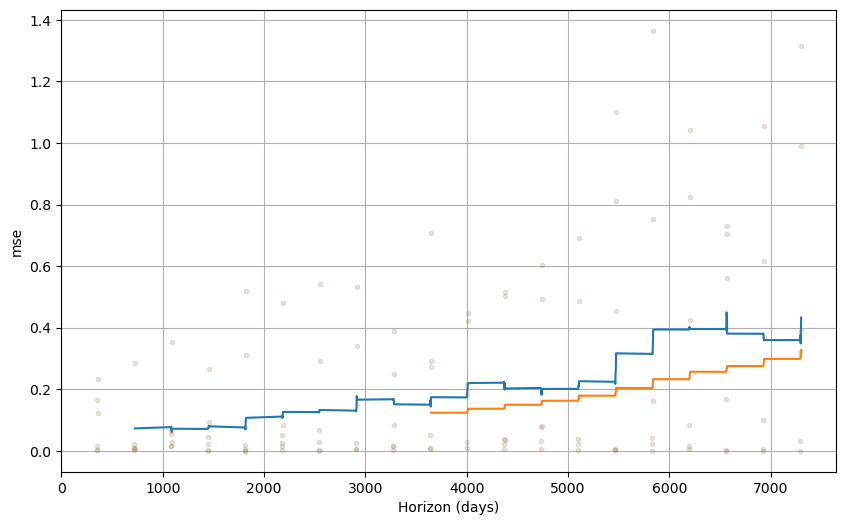

In [13]:

from prophet.plot import plot_cross_validation_metric

fig, ax = plt.subplots(figsize=(10, 6))
plot_cross_validation_metric(df_cv, metric='mse', rolling_window=.1,
                             ax=ax, color='C0')
plot_cross_validation_metric(df_cv, metric='mse', rolling_window=.5,
                             ax=ax, color='C1')
plt.show()

The two curves differ by the amount of averaging used in computing the MSE.
Each point in the blue curved is averaged over 10% of the data while the orange curve is averaged over 50% of the data.
The blue curve is more variable but can give estimates over shorter horizons.
Setting `rolling_window=1` averages over all the data, giving just a single average estimate for the MSE predicting within a 20 year horizon.
A dataframe of metrics can be extracted with `performance_metrics()`:

In [14]:

from prophet.diagnostics import performance_metrics

df_performance = performance_metrics(df_cv, rolling_window=1)
df_performance

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,7300 days,0.225348,0.474709,0.358713,3.293734,1.071312,1.544548,0.375



The above code with `rolling_window=1` is useful for hyperparameter tuning.
It allows us to optimizing average performance over a fixed horizon window.
This is done in the code below to find the optimum seasonality period and number of Fourier terms.
I also optimize over two model parameters `changepoint_prior_scale` and `seasonality_prior_scale` which control the flexibility of the changepoints and seasonalities.
```{margin}
This cell takes a while to run so is not executable, but later cells that analyze `tuning_results.csv` are executable.
```
```python
import itertools

def make_grid_combinations(grid):
    """Turn a dictionary of grid points into a dictionary of all combinations
    of those grid points."""
    all_params = []
    for vals in itertools.product(*grid.values()):
        all_params.append(dict(zip(grid.keys(), vals)))
    return all_params

param_grid = {
    'period': [50, 75, 100],
    'fourier_order': [2, 4, 6],
    'changepoint_prior_scale': [.005, .05, .5],
    'seasonality_prior_scale': [.1, 1, 10],
}
all_params = make_grid_combinations(param_grid)
mses = []

# Cross-validate each combination of grid parameters to estimate MSEs
for params in all_params:
    model = Prophet(
        daily_seasonality = False,
        weekly_seasonality = False,
        yearly_seasonality = False,
        changepoint_prior_scale = params['changepoint_prior_scale'],
        seasonality_prior_scale = params['seasonality_prior_scale']
    )
    model.add_seasonality(
        name = str(params['period']) + ' year',
        period = 365 * params['period'],
        fourier_order = params['fourier_order']
    )
    model.fit(df)

    df_cv = cross_validation(model, initial='36500 days', horizon='7300 days')
    df_performance = performance_metrics(df_cv, rolling_window=1)
    mses.append(df_performance['mse'].values[0])

tuning_results = pd.DataFrame(all_params)
tuning_results['mse'] = mses
tuning_results.to_csv('tuning_results.csv', index=False)
```

The result is stored in a dataframe of cross-validated MSEs and the parameters used in the model:

In [15]:

tuning_results = pd.read_csv('./tuning_results.csv')
tuning_results

,period,fourier_order,changepoint_prior_scale,seasonality_prior_scale,mse
0,50,2,0.005,0.1,0.154416
1,50,2,0.005,1.0,0.155571
2,50,2,0.005,10.0,0.156148
3,50,2,0.050,0.1,0.152661
4,50,2,0.050,1.0,0.154947
...,...,...,...,...,...
76,100,6,0.050,1.0,0.243489
77,100,6,0.050,10.0,0.245329
78,100,6,0.500,0.1,0.108537
79,100,6,0.500,1.0,0.108298


The best parameters, measured by MSE, are easily obtained:

In [16]:
import numpy as np

best_params = tuning_results.iloc[np.argmin(tuning_results['mse']), :]
best_params

period                     75.000000
fourier_order               2.000000
changepoint_prior_scale     0.500000
seasonality_prior_scale    10.000000
mse                         0.048304
Name: 35, dtype: float64

Let's see what the optimized model looks like:

/home/adam/projects/website/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/adam/projects/website/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/adam/projects/website/env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -17.5035
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       302.408    0.00570823       11.3782           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       303.216   0.000781285       20.5453   2.855e-05       0.001      185  LS failed, Hessian reset 
     199       304.138   7.30153e-05        7.3618      0.4801      0.4801      290   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     272       304.446   0.000393317       11.4501   2.713e-05       0.001      419  LS failed, Hessian reset 
     299       304.522   0.000217305       7.42838      0.3201      0.3201      452   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     346       304.735    0.00183216       21.7699   0.0001859       0.001      537  LS failed, Hessian rese

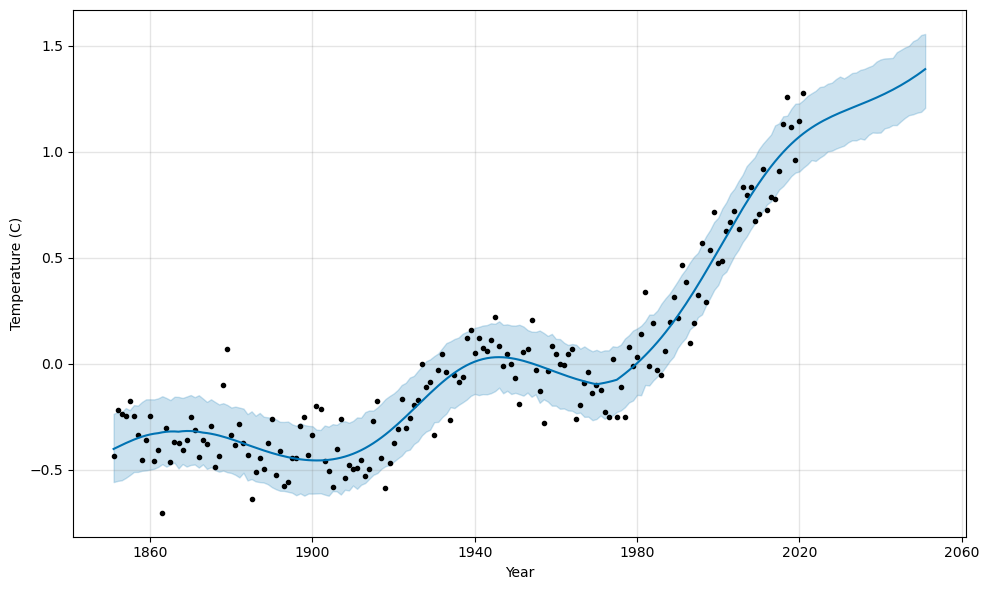

In [17]:

model = Prophet(
    daily_seasonality = False,
    weekly_seasonality = False,
    yearly_seasonality = False,
    changepoint_prior_scale = .5,
    seasonality_prior_scale = 10.0
)
model.add_seasonality('centuryly', period = 365*75, fourier_order = 2)
model.fit(df)
future = model.make_future_dataframe(periods=30, freq='Y')
forecast = model.predict(future)
model.plot(forecast, xlabel='Year', ylabel='Temperature (C)')
plt.show()